# MULTIPLE - Hybrid Spectral Net

In [1]:
%%capture
!python -m pip install -U abraia
!python -m pip install wget

import os

if not os.getenv('ABRAIA_KEY'):
   #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
   abraia_key = ''  #@param {type: "string"}
   %env ABRAIA_KEY=$abraia_key

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abraia import Multiple, hsi

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
 
multiple = Multiple()

## Data loading

In [2]:
dataset = 'IP'
X, y, class_names = hsi.load_dataset(dataset)
X.shape, y.shape

((145, 145, 200), (145, 145))

In [3]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    newX[margin:X.shape[0] + margin, margin:X.shape[1] + margin, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [4]:
windowSize = 25
K = 30 if dataset == 'IP' else 15
X = hsi.principal_components(X, n_components=K)
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [5]:
X_train, X_test, y_train, y_test = hsi.split_train_test(X, y, train_ratio=0.3)

X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)
X_train.shape, y_train.shape

((3074, 25, 25, 30, 1), (3074,))

## Model training and validation

In [6]:
from tensorflow import keras
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Input, Conv2D, Conv3D, Flatten, Dense, Reshape, Dropout

def create_model(window_size, n_bands, output_units):
    ## input layer
    input_layer = Input((window_size, window_size, n_bands, 1))
    ## convolutional layers
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
    conv_layer3 = Reshape((conv_layer3.shape[1], conv_layer3.shape[2], conv_layer3.shape[3] * conv_layer3.shape[4]))(conv_layer3)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    ## fully connected layers
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
    # define the model with input layer and output layer
    model = Model(inputs=input_layer, outputs=output_layer)
    # compiling the model
    adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, batch_size=256, epochs=50):
    history = model.fit(x=X_train, y=np_utils.to_categorical(y_train), batch_size=batch_size, epochs=epochs)
    return history

def evaluate_model(model, X_test, y_test):
    return np.argmax(model.predict(X_test), axis=1)

def predict_model(model, X_pred):
    return np.argmax(model.predict(X_pred), axis=1)

def plot_train_history(history):
    plt.ylim(0, 1.01)
    plt.grid()
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training loss','Test accuracy'], loc='upper right')

Epoch 1/50
13/13 [==============================] - 39s 519ms/step - loss: 2.6689 - accuracy: 0.1490
Epoch 2/50
13/13 [==============================] - 7s 505ms/step - loss: 2.4599 - accuracy: 0.2004
Epoch 3/50
13/13 [==============================] - 7s 505ms/step - loss: 2.2386 - accuracy: 0.2755
Epoch 4/50
13/13 [==============================] - 7s 508ms/step - loss: 1.9339 - accuracy: 0.3445
Epoch 5/50
13/13 [==============================] - 7s 507ms/step - loss: 1.6139 - accuracy: 0.4564
Epoch 6/50
13/13 [==============================] - 7s 513ms/step - loss: 1.2903 - accuracy: 0.5537
Epoch 7/50
13/13 [==============================] - 7s 513ms/step - loss: 0.9296 - accuracy: 0.6890
Epoch 8/50
13/13 [==============================] - 7s 515ms/step - loss: 0.6042 - accuracy: 0.7892
Epoch 9/50
13/13 [==============================] - 7s 511ms/step - loss: 0.4500 - accuracy: 0.8565
Epoch 10/50
13/13 [==============================] - 7s 513ms/step - loss: 0.2979 - accuracy: 0.902

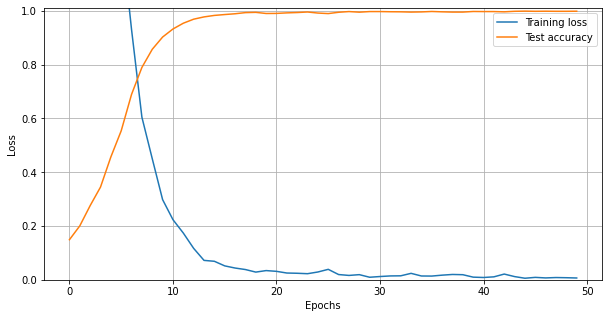

In [7]:
output_units = len(class_names) - 1
model = create_model(windowSize, K, output_units)
history = train_model(model, X_train, y_train)
plot_train_history(history)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = evaluate_model(model, X_test, y_test)

print('Overall accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_names[1:]))
print(confusion_matrix(y_test, y_pred))

## Classification results

In [9]:
def Patch(data, height_index, width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    return data[height_slice, width_slice, :]

In [10]:
X, y, class_names = hsi.load_dataset(dataset)

width, height = y.shape[1], y.shape[0]
PATCH_SIZE = windowSize
numComponents = K

In [11]:
X = hsi.principal_components(X, n_components=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

In [12]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_image = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = predict_model(model, X_test_image)
            outputs[i][j] = prediction + 1
outputs = outputs.astype(int)

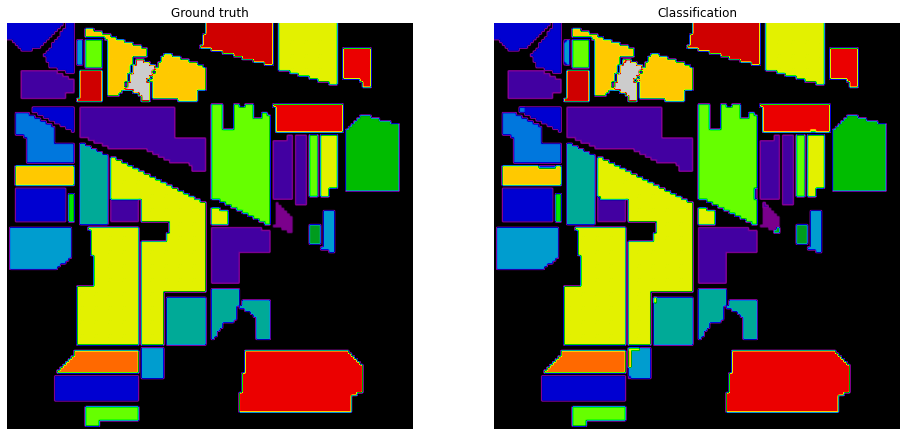

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Ground truth')
plt.imshow(y, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(122)
plt.title('Classification')
plt.imshow(outputs, cmap='nipy_spectral')
plt.axis('off')
plt.show()